<a href="https://colab.research.google.com/github/shumshersubashgautam/Quantum-MNIST-Classification/blob/main/QuantumGradients.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython.display import clear_output
!pip install tensorflow==2.7.0
clear_output()

In [2]:
!pip install tensorflow-quantum==0.7.2
clear_output()

In [3]:
# Update package resources to account for version changes.
import importlib, pkg_resources
importlib.reload(pkg_resources)

<module 'pkg_resources' from '/usr/local/lib/python3.8/dist-packages/pkg_resources/__init__.py'>

In [4]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

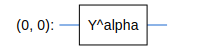

In [5]:
qubit = cirq.GridQubit(0, 0)
my_circuit = cirq.Circuit(cirq.Y(qubit)**sympy.Symbol('alpha'))
SVGCircuit(my_circuit)

In [6]:
pauli_x = cirq.X(qubit)
pauli_x

cirq.X(cirq.GridQubit(0, 0))

In [7]:
def my_expectation(op, alpha):
    """Compute ⟨Y(alpha)| `op` | Y(alpha)⟩"""
    params = {'alpha': alpha}
    sim = cirq.Simulator()
    final_state_vector = sim.simulate(my_circuit, params).final_state_vector
    return op.expectation_from_state_vector(final_state_vector, {qubit: 0}).real


my_alpha = 0.3
print("Expectation=", my_expectation(pauli_x, my_alpha))
print("Sin Formula=", np.sin(np.pi * my_alpha))

Expectation= 0.80901700258255
Sin Formula= 0.8090169943749475


In [8]:
def my_grad(obs, alpha, eps=0.01):
    grad = 0
    f_x = my_expectation(obs, alpha)
    f_x_prime = my_expectation(obs, alpha + eps)
    return ((f_x_prime - f_x) / eps).real


print('Finite difference:', my_grad(pauli_x, my_alpha))
print('Cosine formula:   ', np.pi * np.cos(np.pi * my_alpha))

Finite difference: 1.8063604831695557
Cosine formula:    1.8465818304904567


In [9]:
expectation_calculation = tfq.layers.Expectation(
    differentiator=tfq.differentiators.ForwardDifference(grid_spacing=0.01))

expectation_calculation(my_circuit,
                        operators=pauli_x,
                        symbol_names=['alpha'],
                        symbol_values=[[my_alpha]])

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.80901706]], dtype=float32)>

In [10]:
sampled_expectation_calculation = tfq.layers.SampledExpectation(
    differentiator=tfq.differentiators.ForwardDifference(grid_spacing=0.01))

sampled_expectation_calculation(my_circuit,
                                operators=pauli_x,
                                repetitions=500,
                                symbol_names=['alpha'],
                                symbol_values=[[my_alpha]])

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.848]], dtype=float32)>

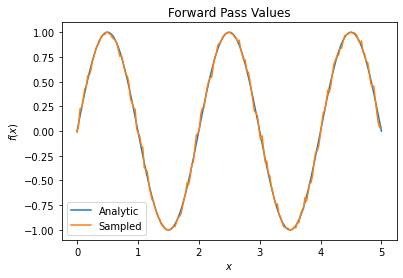

In [11]:
# Make input_points = [batch_size, 1] array.
input_points = np.linspace(0, 5, 200)[:, np.newaxis].astype(np.float32)
exact_outputs = expectation_calculation(my_circuit,
                                        operators=pauli_x,
                                        symbol_names=['alpha'],
                                        symbol_values=input_points)
imperfect_outputs = sampled_expectation_calculation(my_circuit,
                                                    operators=pauli_x,
                                                    repetitions=500,
                                                    symbol_names=['alpha'],
                                                    symbol_values=input_points)
plt.title('Forward Pass Values')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.plot(input_points, exact_outputs, label='Analytic')
plt.plot(input_points, imperfect_outputs, label='Sampled')
plt.legend()

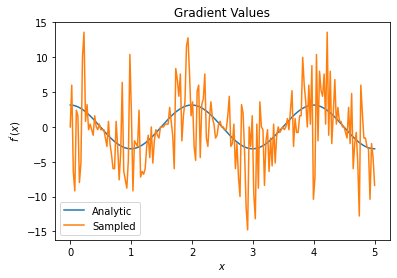

In [12]:
# Gradients are a much different story.
values_tensor = tf.convert_to_tensor(input_points)

with tf.GradientTape() as g:
    g.watch(values_tensor)
    exact_outputs = expectation_calculation(my_circuit,
                                            operators=pauli_x,
                                            symbol_names=['alpha'],
                                            symbol_values=values_tensor)
analytic_finite_diff_gradients = g.gradient(exact_outputs, values_tensor)

with tf.GradientTape() as g:
    g.watch(values_tensor)
    imperfect_outputs = sampled_expectation_calculation(
        my_circuit,
        operators=pauli_x,
        repetitions=500,
        symbol_names=['alpha'],
        symbol_values=values_tensor)
sampled_finite_diff_gradients = g.gradient(imperfect_outputs, values_tensor)

plt.title('Gradient Values')
plt.xlabel('$x$')
plt.ylabel('$f^{\'}(x)$')
plt.plot(input_points, analytic_finite_diff_gradients, label='Analytic')
plt.plot(input_points, sampled_finite_diff_gradients, label='Sampled')
plt.legend()

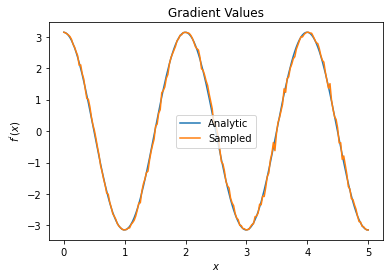

In [13]:
# A smarter differentiation scheme.
gradient_safe_sampled_expectation = tfq.layers.SampledExpectation(
    differentiator=tfq.differentiators.ParameterShift())

with tf.GradientTape() as g:
    g.watch(values_tensor)
    imperfect_outputs = gradient_safe_sampled_expectation(
        my_circuit,
        operators=pauli_x,
        repetitions=500,
        symbol_names=['alpha'],
        symbol_values=values_tensor)

sampled_param_shift_gradients = g.gradient(imperfect_outputs, values_tensor)

plt.title('Gradient Values')
plt.xlabel('$x$')
plt.ylabel('$f^{\'}(x)$')
plt.plot(input_points, analytic_finite_diff_gradients, label='Analytic')
plt.plot(input_points, sampled_param_shift_gradients, label='Sampled')
plt.legend()

In [14]:
pauli_z = cirq.Z(qubit)
pauli_z

cirq.Z(cirq.GridQubit(0, 0))

In [15]:
test_value = 0.

print('Finite difference:', my_grad(pauli_z, test_value))
print('Sin formula:      ', -np.pi * np.sin(np.pi * test_value))

Finite difference: -0.04934072494506836
Sin formula:       -0.0


In [16]:
sum_of_outputs = tfq.layers.Expectation(
    differentiator=tfq.differentiators.ForwardDifference(grid_spacing=0.01))

sum_of_outputs(my_circuit,
               operators=[pauli_x, pauli_z],
               symbol_names=['alpha'],
               symbol_values=[[test_value]])

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[1.9106855e-15, 1.0000000e+00]], dtype=float32)>

In [17]:
test_value_tensor = tf.convert_to_tensor([[test_value]])

with tf.GradientTape() as g:
    g.watch(test_value_tensor)
    outputs = sum_of_outputs(my_circuit,
                             operators=[pauli_x, pauli_z],
                             symbol_names=['alpha'],
                             symbol_values=test_value_tensor)

sum_of_gradients = g.gradient(outputs, test_value_tensor)

print(my_grad(pauli_x, test_value) + my_grad(pauli_z, test_value))
print(sum_of_gradients.numpy())

3.0917350202798843
[[3.0917213]]


In [18]:
class MyDifferentiator(tfq.differentiators.Differentiator):
    """A Toy differentiator for <Y^alpha | X |Y^alpha>."""

    def __init__(self):
        pass

    def get_gradient_circuits(self, programs, symbol_names, symbol_values):
        """Return circuits to compute gradients for given forward pass circuits.

        Every gradient on a quantum computer can be computed via measurements
        of transformed quantum circuits.  Here, you implement a custom gradient
        for a specific circuit.  For a real differentiator, you will need to
        implement this function in a more general way.  See the differentiator
        implementations in the TFQ library for examples.
        """

        # The two terms in the derivative are the same circuit...
        batch_programs = tf.stack([programs, programs], axis=1)

        # ... with shifted parameter values.
        shift = tf.constant(1/2)
        forward = symbol_values + shift
        backward = symbol_values - shift
        batch_symbol_values = tf.stack([forward, backward], axis=1)

        # Weights are the coefficients of the terms in the derivative.
        num_program_copies = tf.shape(batch_programs)[0]
        batch_weights = tf.tile(tf.constant([[[np.pi/2, -np.pi/2]]]),
                                [num_program_copies, 1, 1])

        # The index map simply says which weights go with which circuits.
        batch_mapper = tf.tile(
            tf.constant([[[0, 1]]]), [num_program_copies, 1, 1])

        return (batch_programs, symbol_names, batch_symbol_values,
                batch_weights, batch_mapper)

Text(0.5, 0, 'x')

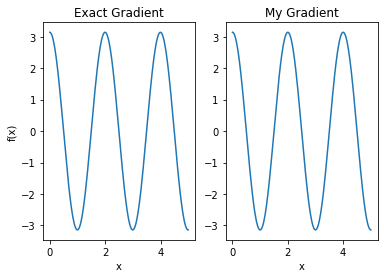

In [19]:
custom_dif = MyDifferentiator()
custom_grad_expectation = tfq.layers.Expectation(differentiator=custom_dif)

# Now let's get the gradients with finite diff.
with tf.GradientTape() as g:
    g.watch(values_tensor)
    exact_outputs = expectation_calculation(my_circuit,
                                            operators=[pauli_x],
                                            symbol_names=['alpha'],
                                            symbol_values=values_tensor)

analytic_finite_diff_gradients = g.gradient(exact_outputs, values_tensor)

# Now let's get the gradients with custom diff.
with tf.GradientTape() as g:
    g.watch(values_tensor)
    my_outputs = custom_grad_expectation(my_circuit,
                                         operators=[pauli_x],
                                         symbol_names=['alpha'],
                                         symbol_values=values_tensor)

my_gradients = g.gradient(my_outputs, values_tensor)

plt.subplot(1, 2, 1)
plt.title('Exact Gradient')
plt.plot(input_points, analytic_finite_diff_gradients.numpy())
plt.xlabel('x')
plt.ylabel('f(x)')
plt.subplot(1, 2, 2)
plt.title('My Gradient')
plt.plot(input_points, my_gradients.numpy())
plt.xlabel('x')

In [20]:
# Create a noisy sample based expectation op.
expectation_sampled = tfq.get_sampled_expectation_op(
    cirq.DensityMatrixSimulator(noise=cirq.depolarize(0.01)))

# Make it differentiable with your differentiator:
# Remember to refresh the differentiator before attaching the new op
custom_dif.refresh()
differentiable_op = custom_dif.generate_differentiable_op(
    sampled_op=expectation_sampled)

# Prep op inputs.
circuit_tensor = tfq.convert_to_tensor([my_circuit])
op_tensor = tfq.convert_to_tensor([[pauli_x]])
single_value = tf.convert_to_tensor([[my_alpha]])
num_samples_tensor = tf.convert_to_tensor([[5000]])

with tf.GradientTape() as g:
    g.watch(single_value)
    forward_output = differentiable_op(circuit_tensor, ['alpha'], single_value,
                                       op_tensor, num_samples_tensor)

my_gradients = g.gradient(forward_output, single_value)

print('---TFQ---')
print('Foward:  ', forward_output.numpy())
print('Gradient:', my_gradients.numpy())
print('---Original---')
print('Forward: ', my_expectation(pauli_x, my_alpha))
print('Gradient:', my_grad(pauli_x, my_alpha))

---TFQ---
Foward:   [[0.7876]]
Gradient: [[1.8328053]]
---Original---
Forward:  0.80901700258255
Gradient: 1.8063604831695557
